<a href="https://www.kaggle.com/code/emmanuelniyioriolowo/ct-hematoma-classifier-v2-multi-class?scriptVersionId=285184339" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Project Setup

In [1]:
# --- Project Setup ---
# Environment configuration and core imports

# Ensuring reproducibility
import os, random
import numpy as np
import torch
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Enforce deterministic behavior (important for stable accuracy)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Core libraries
import pandas as pd
from fastai.vision.all import *

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
# --- Dataset Setup ---
import shutil
from pathlib import Path

test_path = Path('/kaggle/input/hematoma-classifier-validation-dataset/')

src = "/kaggle/input/hematoma-classifier-training-dataset"
dst = "/kaggle/working/hematoma-classifier-training-dataset"

shutil.copytree(src, dst, dirs_exist_ok=True)

path = Path(dst)

In [3]:
# Helper Functions

def compute_accuracy(df):
    """
    Compute per-class and overall accuracy.
    
    Args:
        df (pd.DataFrame): Must contain 'true_label' and 'correct' columns.
    
    Returns:
        sub_acc (pd.Series): Accuracy per class.
        overall (float): Overall accuracy across all samples.
    """
    # Per subcategory (grouped by true_label)
    subcategory_accuracy = (
        df.groupby('true_label')['correct']
        .mean()                           # average True/False = accuracy
        .sort_index()                     # sort alphabetically
    )

    # Overall accuracy
    overall_accuracy = df['correct'].mean()

    return subcategory_accuracy, overall_accuracy

# Data Loading & Preprocessing

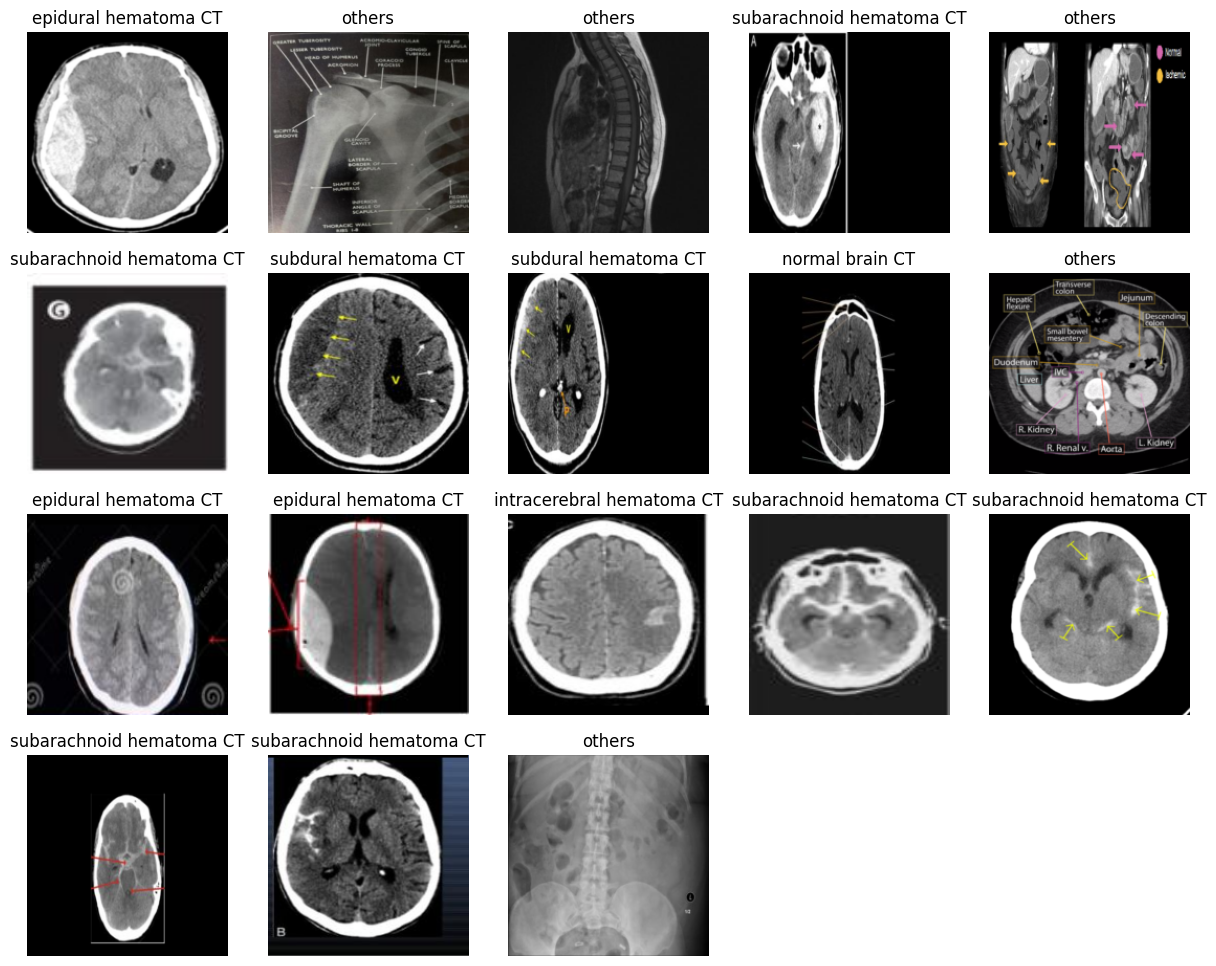

In [4]:
# --- Data Loading & Preprocessing ---

# Create DataLoaders for image classification (80/20 train/valid split)
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(192, method='squish')
).dataloaders(path, bs=32)

dls.show_batch(max_n=18)


# Model Definition & Training

In [5]:
# --- Model Definition & Training ---

metrics = [
    error_rate,
    accuracy,
    Precision(average='macro'),
    Recall(average='macro'),
    F1Score(average='macro')
]

learn = vision_learner(dls, resnet18, metrics=metrics)
learn.fine_tune(5)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 162MB/s]


epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,f1_score,time
0,2.678171,1.722495,0.565789,0.434211,0.523831,0.448158,0.443977,00:03


epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,f1_score,time
0,1.670208,1.529605,0.552632,0.447368,0.454521,0.430698,0.433994,00:01
1,1.299239,1.436549,0.473684,0.526316,0.546133,0.511396,0.521149,00:01
2,0.934959,1.420562,0.526316,0.473684,0.494940,0.466753,0.474604,00:01
3,0.707775,1.431617,0.526316,0.473684,0.481313,0.463479,0.466560,00:01
4,0.560544,1.428437,0.500000,0.500000,0.511966,0.479551,0.488364,00:01


# Evaluation

## Internal validation split

In [6]:
# --- Evaluation: Classification Report ---

preds, targs = learn.get_preds()

# Convert predicted probabilities to class indices
pred_classes = preds.argmax(dim=1)

print(classification_report(targs, pred_classes, target_names=learn.dls.vocab))

                           precision    recall  f1-score   support

     epidural hematoma CT       0.54      0.44      0.48        16
intracerebral hematoma CT       0.36      0.57      0.44        14
          normal brain CT       0.33      0.30      0.32        10
                   others       1.00      0.85      0.92        13
 subarachnoid hematoma CT       0.64      0.50      0.56        14
     subdural hematoma CT       0.20      0.22      0.21         9

                 accuracy                           0.50        76
                macro avg       0.51      0.48      0.49        76
             weighted avg       0.54      0.50      0.51        76



[('normal brain CT', 'intracerebral hematoma CT', 4),
 ('epidural hematoma CT', 'intracerebral hematoma CT', 3),
 ('epidural hematoma CT', 'subdural hematoma CT', 3),
 ('subarachnoid hematoma CT', 'intracerebral hematoma CT', 3),
 ('subdural hematoma CT', 'intracerebral hematoma CT', 3),
 ('epidural hematoma CT', 'normal brain CT', 2),
 ('intracerebral hematoma CT', 'epidural hematoma CT', 2),
 ('intracerebral hematoma CT', 'subdural hematoma CT', 2),
 ('normal brain CT', 'subarachnoid hematoma CT', 2),
 ('subarachnoid hematoma CT', 'subdural hematoma CT', 2),
 ('subdural hematoma CT', 'epidural hematoma CT', 2),
 ('subdural hematoma CT', 'normal brain CT', 2)]

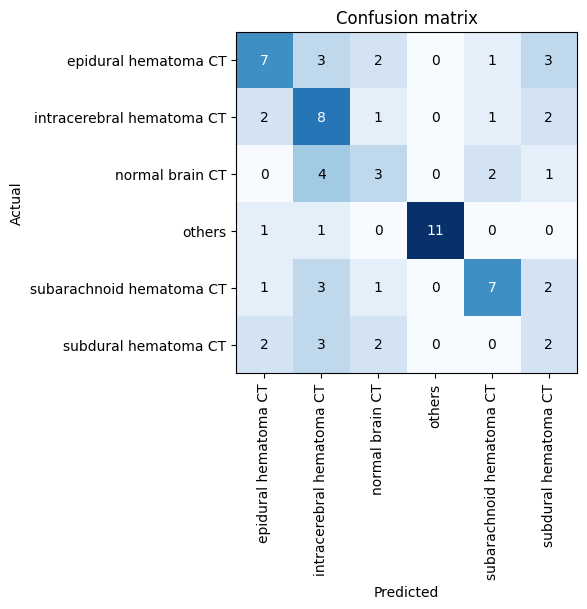

In [7]:
# --- Evaluation: Confusion Matrix & Error Analysis ---

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6, 6), dpi=100)

interp.most_confused(min_val=2)

## External dataset

In [8]:
# --- Evaluation: Validation Set Predictions ---

test_path = Path("/kaggle/input/hematoma-classifier-validation-dataset")

results = []

for img_path in test_path.rglob("*"):
    if img_path.suffix.lower() in [".jpg", ".jpeg", ".png"]:
        
        true_label = img_path.parent.name
        
        # Model prediction
        pred_class, pred_idx, probs = learn.predict(img_path)

        # Correctness logic for cases involving "not-" labels
        if true_label in pred_class and "not" not in pred_class:
            correct = True
        elif true_label not in pred_class and "not" in pred_class:
            correct = True
        else:
            correct = False
        
        results.append({
            "filename": img_path.name,
            "true_label": true_label,
            "predicted_class": pred_class,
            "correct": correct
        })

df_results = pd.DataFrame(results)
df_results.head(60)

,filename,true_label,predicted_class,correct
0,epidural 4.jpg,epidural,intracerebral hematoma CT,False
1,epidural 3.jpg,epidural,epidural hematoma CT,True
2,epidural 10.jpg,epidural,epidural hematoma CT,True
3,epidural 8.jpg,epidural,epidural hematoma CT,True
4,epidural 1.jpg,epidural,normal brain CT,False
5,epidural 9.jpg,epidural,intracerebral hematoma CT,False
6,epidural 11.jpeg,epidural,normal brain CT,False
7,epidural .jpg,epidural,intracerebral hematoma CT,False
8,epidural 7.jpeg,epidural,intracerebral hematoma CT,False
9,epidural 6.jpg,epidural,subarachnoid hematoma CT,False


In [9]:
# --- Evaluation: Accuracy Summary - Per Categroy---

subcategory_acc, overall_acc = compute_accuracy(df_results)

print("Accuracy per subcategory:\n", subcategory_acc)
print(f"\nOverall accuracy: {overall_acc * 100:.2f}%")

Accuracy per subcategory:
 true_label
epidural         0.250000
intracerebral    0.636364
normal           0.375000
others           0.300000
subarachnoid     0.900000
subdural         0.384615
Name: correct, dtype: float64

Overall accuracy: 46.88%


In [10]:
# --- Evaluation: Text Label Normalization & Classification Report ---

# Normalize predicted labels (take first word before any spaces)
y_pred = df_results['predicted_class'].str.split().str[0]
y_true = df_results['true_label']

print(classification_report(y_true, y_pred))

               precision    recall  f1-score   support

     epidural       0.50      0.25      0.33        12
intracerebral       0.30      0.64      0.41        11
       normal       0.38      0.38      0.38         8
       others       1.00      0.30      0.46        10
 subarachnoid       0.64      0.90      0.75        10
     subdural       0.50      0.38      0.43        13

     accuracy                           0.47        64
    macro avg       0.55      0.47      0.46        64
 weighted avg       0.55      0.47      0.46        64



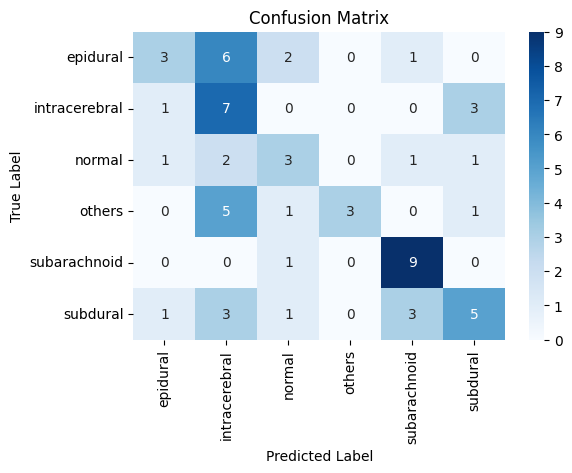

In [11]:
# --- Evaluation: Confusion Matrix (Seaborn) ---

labels = sorted(y_true.unique())
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [12]:
# # Downloads and displays a 256×256 thumbnail of an intracerebral hematoma CT image.
# test_image = "thoracic ct"
# urls = search_images(test_image, max_images=1)
# dest = f'{test_image}.jpg'
# download_url(urls[0], dest, show_progress=False)

# from fastai.vision.all import *
# img = Image.open(dest)
# img.to_thumb(256,256)

In [13]:
# # Predicts the hematoma type from the image and displays the predicted category with its probability.
# resultant_category,_,probs = learn.predict(PILImage.create(f'{test_image}.jpg'))
# print(f"Predicted category: {resultant_category}")
# print(f"Probability of epidural hematoma: {probs[0]:.4f}")

In [14]:
# # Creates and displays an image upload widget for selecting a single image file. To test with local files
# from ipywidgets import FileUpload
# from fastai.vision.all import PILImage

# # Display uploader
# uploader = FileUpload(accept='image/*', multiple=False)
# display(uploader)

In [15]:
# # Loads the uploaded image, uses the trained model to predict its category, and displays the prediction with class probabilities.

# if uploader.value:
#     uploaded_file = uploader.value[0]
#     img_bytes = bytes(uploaded_file['content']) 

#     img = PILImage.create(img_bytes)  

#     # Predict
#     resultant_category, _, probs = learn.predict(img)
#     print(f"Predicted category: {resultant_category}")
#     print(f"Probabilities: {probs}")
# else:
#     print("Please upload an image first.")